In [1]:
import numpy as np
import pylab as plb
import math
import copy
import matplotlib.pyplot as plt
from math import pi
import ThPa2D
import twoflow as flow
import matplotlib.pyplot as plot
#import profile_plots as pp
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm




def initialize(timesteps):
    ''' initialize the physical system, horizontal grid size, etc
    '''  
    # below are the parameters that can be varied
    dx = 100.
    u = 0.
    dz = 100.
    v = 0.
    dt = 0.01
    alpha =  0.01*10.
    epsilon = 0.0001
    
# create the concentration matrix and initialize it
    cmatrix=np.zeros((2, Numpoints+4,Numpoints+4))
    c2matrix=np.zeros((2, Numpoints+4,Numpoints+4))
    diss = np.zeros((timesteps+1, Numpoints+4,Numpoints+4))
    part = np.zeros((timesteps+1, Numpoints+4,Numpoints+4))
    
    return dx, dz, u, v, dt, Numpoints, epsilon, cmatrix,c2matrix

def boundary_conditions(cmatrix, time, Numpoints):
    '''Set boundary conditions (double thick so it work for Bott Scheme as well as central and upstream
    '''
    cmatrix[0, 0,:] = cmatrix[1, Numpoints-1,:]
    cmatrix[0, 1,:] = cmatrix[1, Numpoints,:]
    cmatrix[0, Numpoints+2,:] = cmatrix[1, 3,:]
    cmatrix[0, Numpoints+3,:] = cmatrix[1, 4,:]
    
    cmatrix[0, :,0] = cmatrix[1, :,Numpoints-1]
    cmatrix[0, :,1] = cmatrix[1, :,Numpoints]
    cmatrix[0, :,Numpoints+2] = cmatrix[1, :,3]
    cmatrix[0, :,Numpoints+3] = cmatrix[1, :,4]
    
    return cmatrix


def advect3_gettable(order, Numpoints):
    
    '''read in the corresponding coefficient table for the calculation of coefficients for advection3
    '''

# create a matrix to store the table to be read in
    temp = np.zeros(5)
    ltable = np.zeros((order + 1, 5))

    fname = 'numeric/numlabs/lab10/Tables/l{0}_table.txt'.format(order)
    fp = open(fname, 'r')
 
    for i in range(order+1):
        line = fp.readline()
        temp = line.split()
        ltable[i, :]= temp
        
    fp.close()
    return ltable

    
    
def advect_xz(ltable, cmatrix, order, Numpoints, u, v, dt, dx, dz, epsilon):
    '''Step algorithm for Bott Scheme'''
    amatrix = np.zeros((order+1, Numpoints))
    timecount=0
    # concentration in z dir
    for numz in range (2,Numpoints+2):
        for base in range(0,5):
            amatrix[0:order+1, 0:Numpoints] += np.dot(
                ltable[0:order+2, base:base+1], 
                cmatrix[timecount:timecount+1, 0+base:Numpoints+base, numz])

        Iplus = np.zeros(Numpoints)
        Iatj = np.zeros(Numpoints)

        tempvalue= 1 - 2*v*dt/dz
        for k in range(order+1):
            Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))
            Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))
        Iplus[Iplus < 0] = 0
        Iatj = np.maximum(Iatj, Iplus + epsilon)


        cmatrix[timecount, 3:Numpoints+2,numz] = (
            cmatrix[timecount, 3:Numpoints+2,numz] * 
            (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
             cmatrix[timecount, 2:Numpoints+1,numz]* 
             Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])
    # concentration in x dir
    for numx in range (2,Numpoints+2):
        for base in range(0,5):
            amatrix[0:order+1, 0:Numpoints] += np.dot(
                ltable[0:order+2, base:base+1], 
                cmatrix[timecount:timecount+1,numx, 0+base:Numpoints+base])

        Iplus = np.zeros(Numpoints)
        Iatj = np.zeros(Numpoints)

        tempvalue= 1 - 2*u*dt/dx
        for k in range(order+1):
            Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))
            Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))
        Iplus[Iplus < 0] = 0
        Iatj = np.maximum(Iatj, Iplus + epsilon)


        cmatrix[timecount+1, numx,3:Numpoints+2] = (
            cmatrix[timecount, numx,3:Numpoints+2] * 
            (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
             cmatrix[timecount, numx, 2:Numpoints+1]* 
             Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])                      
            
            
        #left boundary
        cmatrix[timecount+1, 2,:]= cmatrix[timecount+1, 3,:]
        #surface boundary
        cmatrix[timecount+1, :,2]= cmatrix[timecount+1, :,3]
        #right boundary
        cmatrix[timecount+1, Numpoints+2,:]= cmatrix[timecount+1, Numpoints+1,:]
        #bottom boundary
        cmatrix[timecount+1, :,Numpoints+2]= cmatrix[timecount+1, :,Numpoints+1]

    return cmatrix[timecount+1, :,:]


def tracer(diss,part,timesteps, order):
    dx, dz,u, v,dt, Numpoints, epsilon, cmatrix, c2matrix = initialize(timesteps)
    ltable = advect3_gettable(order, Numpoints)

    for t in range (timesteps): 
        for z in range (Numpoints+2):
        #chem model
            part[2,:]=0
            
            diss_pre=diss
            part_pre=part
            diss += ( Q - k_ad[z,:] * diss_pre + k_de * part_pre) * dt
            
            if z!=0:
                sinking=500*(part_pre[z,:]-part_pre[z-1,:])/dz
                part[z,:] += ( k_ad[z,:] * diss_pre[z,:]- k_de * part_pre[z,:] - sinking) * dt
            else:
                part[z,:] =0
                
        #phy model
        #cmatrix[0,:,:]=diss
        #c2matrix[0,:,:]=part
        #advd=advect_xz(ltable, cmatrix, order, Numpoints, u, v,     dt, dx, dz, epsilon)
        #advp=advect_xz(ltable, c2matrix, order, Numpoints,u, v+5, dt, dx, dz, epsilon)
        
        #diss += advd
        #part += advp
        
    return diss,part
    

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
def plot(Hu,x,y,timestep,j1,j2,j3):
    
    ax = fig.add_subplot(j1, j2, j3+1)
    X = np.linspace(0, x,x,endpoint=False)
    Y = np.linspace(0, y,y,endpoint=False)
    X, Y = np.meshgrid(X, Y)
    Z = Hu[2:-2,2:-2]#(Hu**2+Hv**2)**0.5
    
    plt.pcolor(X, Y, Z)
    ax.set_title('t:%syr'%(timestep+1))
    ax.invert_yaxis()
    plt.colorbar()

In [10]:
coeff=100
yr=15
t=yr*coeff
Numpoints = 50

# chemistry
k_ad = np.zeros((Numpoints+4,Numpoints+4))
k_ad[:,:]=0.6
k_ad[:,10:]=0.4
k_de= 1.0
Q =0.0267 

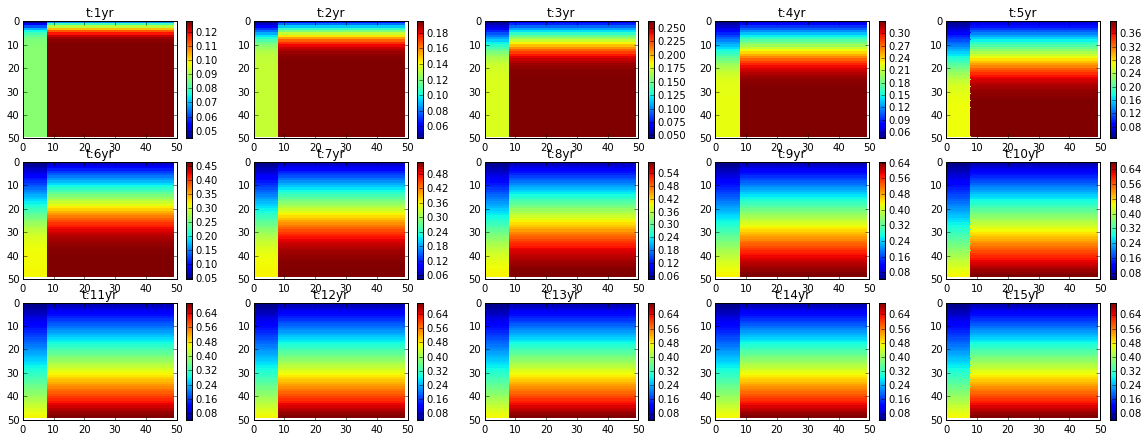

In [11]:
diss = np.zeros((Numpoints+4,Numpoints+4))
disst= np.zeros((yr,Numpoints+4,Numpoints+4))
part = np.zeros((Numpoints+4,Numpoints+4))
partt= np.zeros((yr,Numpoints+4,Numpoints+4))

fig = plt.figure(figsize=(20,50))
for j in range (t):
    diss,part=tracer(diss,part,1,4)
    k=(j+1)%coeff
    if k==0 and j!=0:
        disst[j/coeff,:,:]=diss
        partt[j/coeff,:,:]=part
        plot(diss,Numpoints,Numpoints,timestep=j/coeff,j1=20,j2=5,j3=j/coeff)
plt.show()

/home/xiaoxiny/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


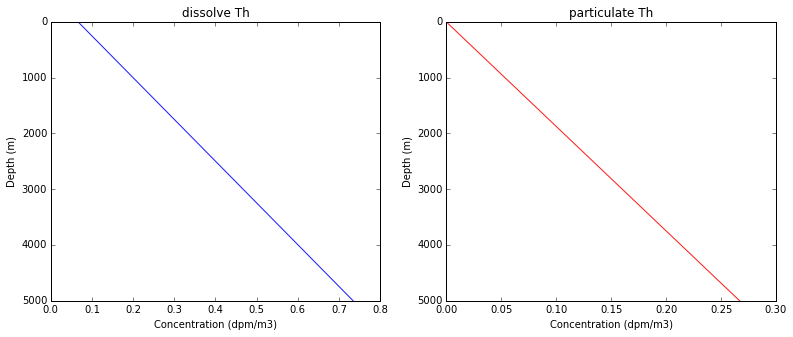

In [12]:
Q_Th=0.0267
s_Th=500
c_Th=0
k_Th=0.4      #absorption rate
j_Th=1.0    #desorption rate


fig = plt.figure(1, figsize=(13,5)) 
#fig1
plt.subplot(1, 2, 2)
z = np.linspace(0,5000,100,endpoint=True)
x_Th_part = np.array(Q_Th/s_Th*z+c_Th)
plt.plot(x_Th_part, z, color='red', alpha=0.90)

plt.gca().invert_yaxis()
plt.title('particulate Th')
plt.ylabel('Depth (m)')
plt.xlabel('Concentration (dpm/m3)')
plt.legend()


plt.subplot(1, 2, 1)
z = np.linspace(-5000,0,100,endpoint=True)
x_Th = np.array(Q_Th/k_Th-j_Th/k_Th*(Q_Th/s_Th*z+c_Th))
plt.plot (x_Th, -z, color='blue', alpha=0.90)

plt.gca().invert_yaxis()
plt.title('dissolve Th')
plt.ylabel('Depth (m)')
plt.xlabel('Concentration (dpm/m3)')
plt.legend()

plt.show()

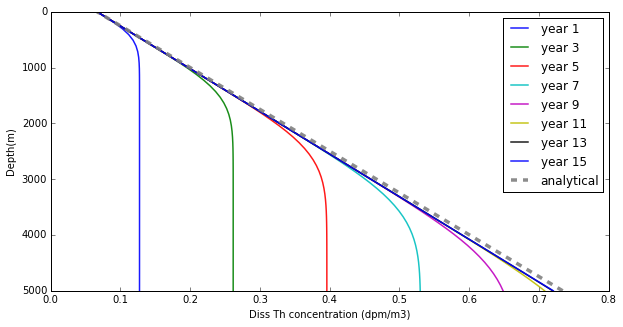

In [13]:
fig = plt.figure(figsize=(10,5))
for i in range(0,len(disst[:,0,0]),2):
    plt.plot(disst[i,2:52,30],np.linspace(0,5000,50),linewidth=1.5,label='year %s'%(i+1),alpha=0.9)
    plt.hold(True)
plt.plot(x_Th,-z,'--',linewidth=3.5,label='analytical',color='grey',alpha=0.9)    
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('Depth(m)')
plt.xlabel('Diss Th concentration (dpm/m3)')
plt.show()

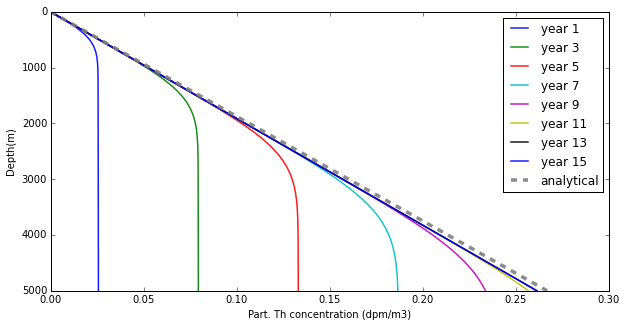

In [131]:
fig = plt.figure(figsize=(10,5))
for i in range(0,len(disst[:,0,0]),2):
    plt.plot(partt[i,2:52,30],np.linspace(0,5000,50),linewidth=1.5,label='year %s'%(i+1),alpha=0.9)
    plt.hold(True)
plt.plot(x_Th_part,z+5000,'--',linewidth=3.5,label='analytical',color='grey',alpha=0.9)  
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('Depth(m)')
plt.xlabel('Part. Th concentration (dpm/m3)')
plt.show()

In [62]:
#test my chemical model

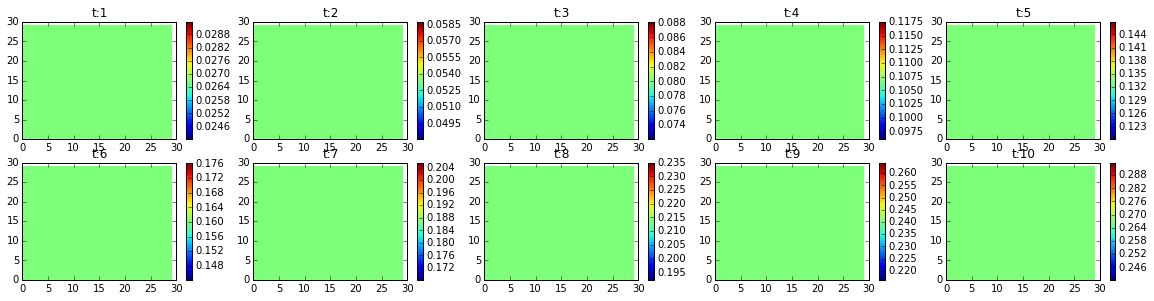

In [95]:
diss = np.zeros((34, 34))
part = np.zeros((34, 34))
t=5*10

fig = plt.figure(figsize=(20,50))
for j in range (t):
    diss,part=tracer(diss,part,1,4)
    k=(j+1)%5
    if k==0 and j!=0:
        plot(diss,30,30,timestep=j/5,j1=20,j2=5,j3=j/5)
plt.show()